In [663]:
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model

In [454]:
df = pd.read_csv('bit/BTC_USD_2019-04-01_2020-05-09-CoinDesk.csv')

In [455]:
df.index = pd.to_datetime(df['Date'])

In [456]:
df.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,,
2019-04-01,BTC,2019-04-01,4135.184940,4094.704791,4148.661800,4052.601676
2019-04-02,BTC,2019-04-02,4818.770635,4135.182905,4961.780306,4132.556660
2019-04-03,BTC,2019-04-03,5102.150753,4818.773504,5325.233877,4810.244974
2019-04-04,BTC,2019-04-04,4875.599431,4966.901630,5071.589614,4787.707994
2019-04-05,BTC,2019-04-05,5030.933271,4875.596147,5060.703203,4875.596147


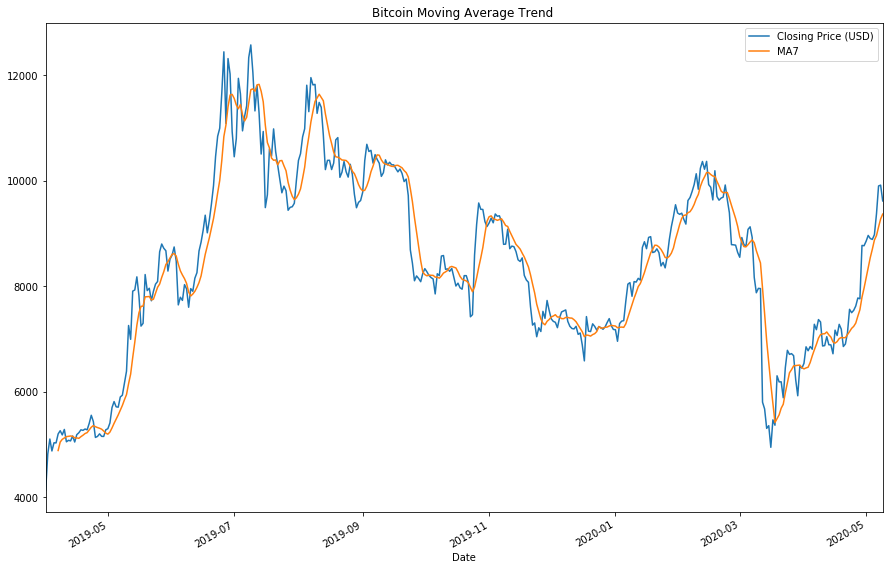

In [457]:
# visualization

# set a moving average in 7 days
df['MA7'] = df['Closing Price (USD)'].rolling(window=7).mean()
df[['Closing Price (USD)','MA7']].plot(kind='line', figsize=[15,10], title='Bitcoin Moving Average Trend ')


From the plot, we can have a better overview when is a better timing to invest in bitcoin. When the price is below the line of moving average, its a better time to invest in.

Next, we focus on building forecasting models

## Time series model with ARIMA

In [458]:
# checking for stationary

result = adfuller(df['Closing Price (USD)'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.697139
p-value: 0.074535
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


In [470]:
df1 = df['Closing Price (USD)']

H0 null hypothesis: this model is stationary

P-value of 0.07 means we still have 7% of chances that we consider this model stationary when it is not. If we set the alpha threshold as 10%, this false positive error rate is acceptable. Hence, we can reject the null hypothesis, proving that it is stationary

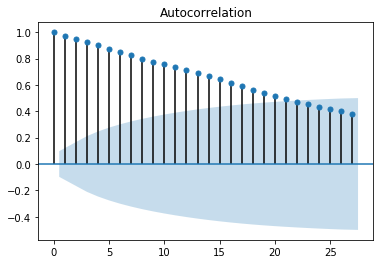

In [471]:
# ACF plot

sm.graphics.tsa.plot_acf(df1)
plt.show()

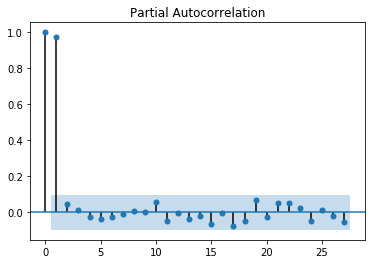

In [472]:
# PACF

sm.graphics.tsa.plot_pacf(df1)
plt.show()

From the acf and pacf plot, we can clearly tell that there is no seasonality. Also, this data follows an AR(2) model with 2 bars extremely outstanding in pacf plot. We can test for more eacf plot

In [463]:
sm.tsa.arma_order_select_ic(df1,ic=['aic', 'bic'])

/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning

{'aic':              0            1            2
 0  7184.076800  6744.155889  6464.470328
 1  5881.046755  5882.904244  5884.885786
 2  5882.903118  5884.549920  5881.329698
 3  5884.888270  5886.538713  5887.355176
 4  5886.723149  5885.559864  5885.392813,
 'bic':              0            1            2
 0  7192.079630  6756.160134  6480.475987
 1  5893.051000  5898.909904  5904.892860
 2  5898.908778  5904.556994  5905.338187
 3  5904.895344  5910.547202  5915.365080
 4  5910.731638  5913.569768  5917.404132,
 'aic_min_order': (1, 0),
 'bic_min_order': (1, 0)}

From the eacf plot, we can see that the algorithm suggest AR(1) model. Since aic and bic score from  AR(1) and AR(2) do not vary a lot, we pick the AR(2) model.

In [502]:
df_train = df['Closing Price (USD)'][:320]
df_test = df['Closing Price (USD)'][320:]

In [514]:
# fit into a ARIMA model with order (2,0,0)

model = ARIMA(df_train, order=(2,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                               ARMA Model Results                              
Dep. Variable:     Closing Price (USD)   No. Observations:                  320
Model:                      ARMA(2, 0)   Log Likelihood               -2317.826
Method:                        css-mle   S.D. of innovations            336.442
Date:                 Sat, 09 May 2020   AIC                           4643.651
Time:                         21:37:30   BIC                           4658.724
Sample:                              0   HQIC                          4649.670
                                                                               
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      8070.1239   1320.492      6.111      0.000    5482.006    1.07e+04
ar.L1.Closing Price (USD)     0.9604      0.056     17.065      0.000       0.

/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


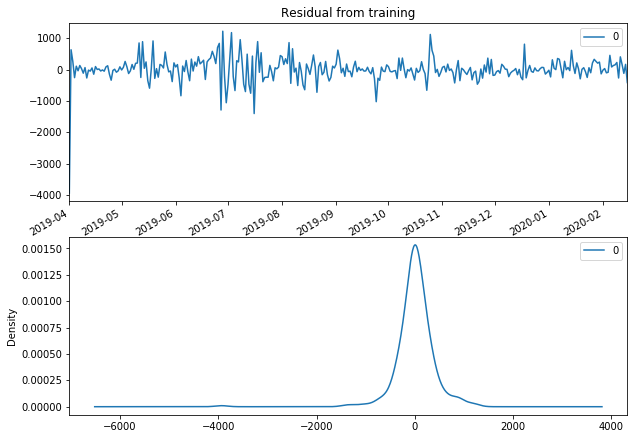

-----------------------------
Model Summary
                 0
count   320.000000
mean     12.316680
std     400.972905
min   -3934.938971
25%    -117.370131
50%      12.546728
75%     170.819078
max    1227.813047


In [508]:
# visualize the time series model

residuals = pd.DataFrame(model_fit.resid)

fig, axes = plt.subplots(nrows=2, ncols=1)
residuals.plot(title = 'Residual from training',ax=axes[0], figsize = [10,8])
residuals.plot(kind='kde',ax=axes[1], figsize = [10,8])
plt.show()

print('-----------------------------')
print('Model Summary')
print(residuals.describe())

/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


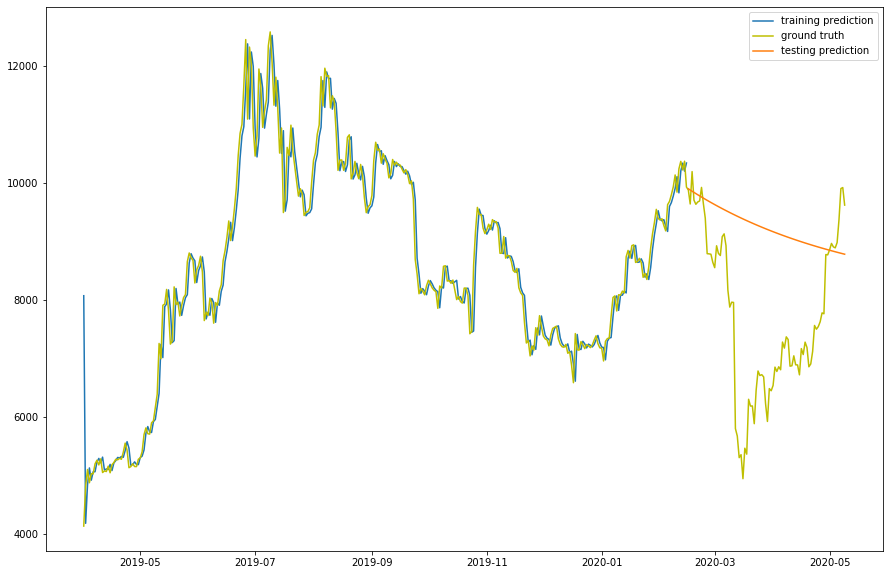

In [938]:
# validate on the testing data

model_fit.predict(start=319,end=403)[1:]

plt.figure(figsize=(15,10))
plt.plot(df_train.index, model_fit.predict().values, label='training prediction')
plt.plot(df1.index, df1.values, 'y', label='ground truth')
plt.plot(df_test.index, model_fit.predict(start=320,end=404)[1:], label='testing prediction')
plt.legend(['training prediction', 'ground truth', 'testing prediction'])
plt.show()

In [934]:
# testing rmse
rmse_arima = ((((df_test.values-model_fit.predict(start=320,end=404)[1:]).values)**2).mean())**0.5
print('rmse:',rmse_arima)

rmse: 2021.9362293750494


/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


With only fitting data into a time sereis model, the rmse = 2021

-------------------------------------------

## Polynomial regression model + Time series model 


We now try fit the model into a polynomial regression first and then fit the residual into time sereis model, seeing if the rmse can decrease

Fit the data to a linear regression first, and I choose a ploynomial regression to better fit the data

In [906]:
reg = linear_model.LinearRegression() 

# fit data into regression: y = a*x + b*x^2 + c*x^0.5 + d*x^1.5 

# generate parameters for training
x_train = pd.DataFrame({'x': [i for i in range(0,df_train.shape[0])], 
                        'x^2': [i**2 for i in range(0,df_train.shape[0])],
                        'x^0.5': [i**0.5 for i in range(0,df_train.shape[0])],
                        'x^1.5': [i**0.5 for i in range(0,df_train.shape[0])]}).values


lin_model = reg.fit(x_train, df_train.values.reshape(-1,1)) 
print('Coefficients: \n', lin_model.coef_) 

Coefficients: 
 [[-9.14737115e+01  4.59966624e-02  8.96915829e+02  8.96915829e+02]]


In [907]:
# generate parameters for testing

x_test = pd.DataFrame({'x': [i for i in range(320,df1.shape[0])], 
                       'x^2': [i**2 for i in range(320,df1.shape[0])],
                       'x^0.5': [i**0.5 for i in range(320,df1.shape[0])],
                       'x^1.5': [i**0.5 for i in range(320,df1.shape[0])]}).values


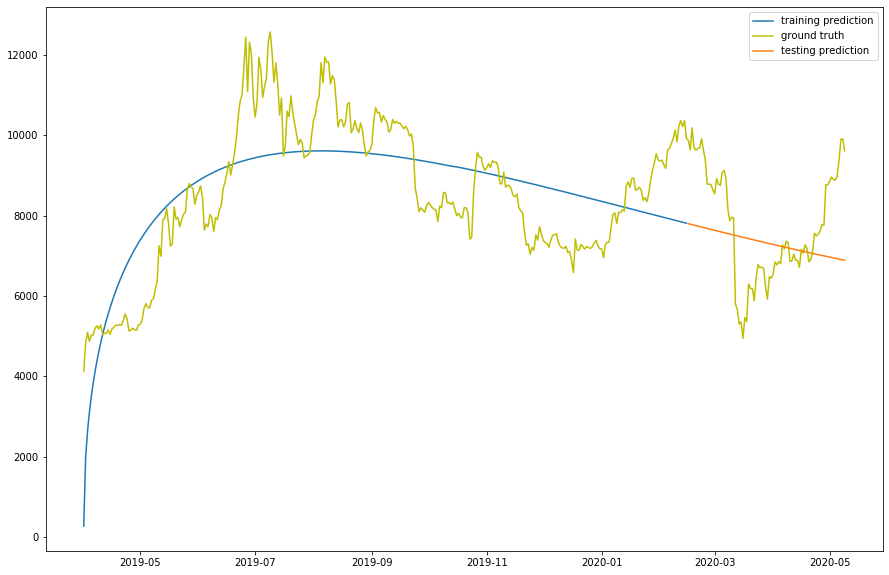

In [935]:
# visualize the predictions for polynomial regression model

plt.figure(figsize=(15,10))
plt.plot(df_train.index, lin_model.predict(x_train), label='training prediction')
plt.plot(df1.index, df1.values, 'y', label='ground truth')
plt.plot(df_test.index, lin_model.predict(x_test), label='testing prediction')
plt.legend(['training prediction', 'ground truth', 'testing prediction'])
plt.show()

In [909]:
# generate residual and feed into time series model

resid = df_train.values - lin_model.predict(x_train).reshape(1,-1)
resid = pd.DataFrame({'Date':df_train.index, 'resid':resid.flatten()})
resid.set_index('Date', inplace=True)

In [910]:
resid['resid']

Date
2019-04-01    3860.476952
2019-04-02    2841.658705
2019-04-03    2473.345143
2019-04-04    1767.891037
2019-04-05    1533.720867
                 ...     
2020-02-11    2374.773833
2020-02-12    2515.019353
2020-02-13    2380.135023
2020-02-14    2541.492969
2020-02-15    2112.235436
Name: resid, Length: 320, dtype: float64

In [911]:
# fit residuals to ARIMA model

# check for stationary

result_resid = adfuller(resid['resid'])
print('ADF Statistic: %f' % result_resid[0])
print('p-value: %f' % result_resid[1])
print('Critical Values:')
for key, value in result_resid[4].items():
    print('\t%s: %.3f' % (key, value))
    
# Stationary

ADF Statistic: -3.209922
p-value: 0.019417
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


In [912]:
# eacf get the best parameters for p,q

sm.tsa.arma_order_select_ic(resid,ic=['aic', 'bic'])

/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning

{'aic':              0            1            2
 0  5471.531628  5149.272498  4981.706190
 1  4651.557465  4653.539449  4655.464009
 2  4653.538792  4648.960212  4650.929834
 3  4655.451342  4650.848521  4652.844318
 4  4655.876734  4652.871812  4654.266495,
 'bic':              0            1            2
 0  5479.068270  5160.577461  4996.779474
 1  4662.862428  4668.612733  4674.305614
 2  4668.612076  4667.801817  4673.539760
 3  4674.292947  4673.458447  4679.222565
 4  4678.486660  4679.250059  4684.413063,
 'aic_min_order': (2, 1),
 'bic_min_order': (1, 0)}

From the eacf results, ARMA(2,1) model will be used

In [919]:
# fit into a ARIMA model with order (2,0,1)

model_la = ARIMA(resid['resid'], order=(2,0,1))
model_la_fit = model_la.fit(disp=0)
print(model_la_fit.summary())

/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  resid   No. Observations:                  320
Model:                     ARMA(2, 1)   Log Likelihood               -2319.480
Method:                       css-mle   S.D. of innovations            337.330
Date:                Sun, 10 May 2020   AIC                           4648.960
Time:                        00:37:43   BIC                           4667.802
Sample:                             0   HQIC                          4656.484
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         173.0181    123.645      1.399      0.163     -69.321     415.357
ar.L1.resid     1.9727      0.013    147.286      0.000       1.946       1.999
ar.L2.resid    -0.9744      0.013    -72.851    

In [920]:
# add the predicted values of linear model and arima model from training data 

final_pred_train = model_la_fit.predict().values + lin_model.predict(x_train).flatten()


In [921]:
# add the testing data predicted values of linear model and arima model to form the final predictions

final_pred_test = model_la_fit.predict(start=320,end=404)[1:].values + lin_model.predict(x_test).flatten()

/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [922]:
final_pred_rmse = (((df_test.values-final_pred)**2).mean())**0.5
final_pred_rmse

1384.5931250441242

With the help of polynimoal regression model, this combined method considerably decrease the rmse and boost the performance

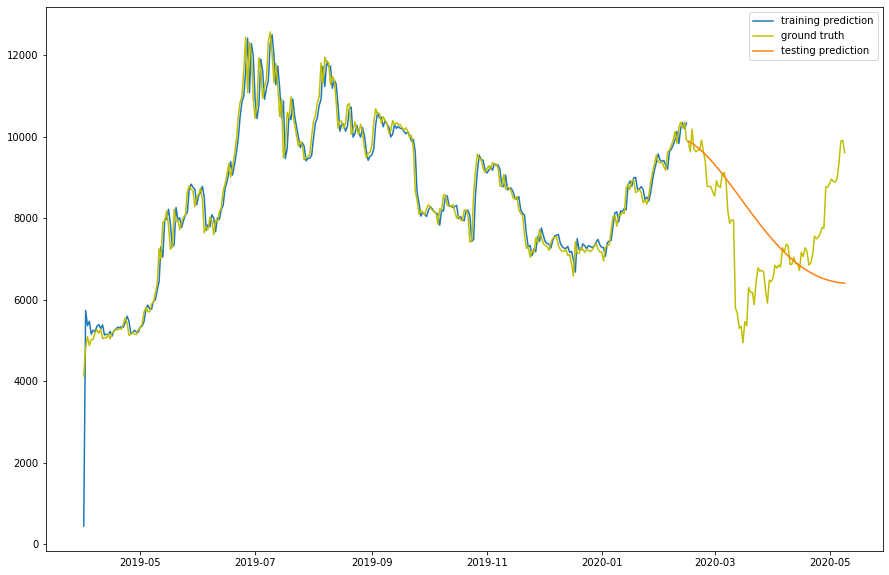

In [923]:
# visualize the predictions

plt.figure(figsize=(15,10))
plt.plot(df_train.index, final_pred_train, label='training prediction')
plt.plot(df1.index, df1.values, 'y', label='ground truth')
plt.plot(df_test.index, final_pred_test, label='testing prediction')
plt.legend(['training prediction', 'ground truth', 'testing prediction'])

# Done

In [941]:
conclusion = pd.DataFrame({'arima only':[rmse_arima],'arima+poly': [final_pred_rmse]}, index=['rmse'])
conclusion

,arima only,arima+poly
rmse,2021.936229,1384.593125


From the plots, you can see the poly+arima will have a smaller error in predicting, almost 40% more accurate, and the lines of ground truth and predictions are more aligned to each other. This method is like a ensembling model, which can help improve the accuracy of the model. A better aproach also when doing forecasting analysis if the data exist some trends that can be observed!